<a href="https://colab.research.google.com/github/bergeramit/Cactus/blob/master/test_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Settings

In [14]:
!pip install eta

  Created wheel for eta: filename=eta-0.9.7-cp37-none-any.whl size=3279 sha256=15879c040d235c646c7d3d3be9791cf291edb7daa9bfdcbd4ebe964d68a87196
  Stored in directory: /root/.cache/pip/wheels/8f/3d/be/b39717b4cd2bb43eb1914b692e663cbad000b32358878f13ba
Successfully built eta


In [15]:
import os
import csv
from pathlib import Path

import cv2
import math

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import ndimage as ndi
from sklearn import preprocessing 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D

import networkx as nx

import pandas as pd
import scipy.misc
import glob
import scipy.misc

import eta


In [2]:
GIST_FEATURES_DIR_PATH = "/content/drive/MyDrive/CD_Project_drive/GIST_features"
LABELS_PATH = "/content/drive/MyDrive/CD_Project_drive/trainLabels.csv"
LABELS = ['Ramnit', 'Lollipop', 'Kelihos_ver3', 'Vundo', 'Simda', 'Tracur', 'Kelihos_ver1', 'Obfuscator.ACY', 'Gatak']
TRAIN_SET_PORTION = 0.90

# Gist Descriptor

In [3]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i

def plot_single(gs):
    (kernel, powers) = gs
    a = (kernel * 255).astype(np.uint8)
    plt.figure()
    plt.imshow(a, 'gray')
    
def power_single(gs):
    (kernel, powers) = gs
    return powers*255

def implot(im, gray=False):
    cv_rgb = cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    
def np2to3(im):
    # convert 2d to 3d naively
    new_im = np.zeros((im.shape[0], im.shape[1], 3))
    r, c = im.shape
    for x in range(r):
        for y in range(c):
            new_im[x, y, :] = im[x,y]
    return new_im

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(ndi.convolve(image, np.real(kernel), mode='wrap')**2 +
                   ndi.convolve(image, np.imag(kernel), mode='wrap')**2)

def compute_avg(img):
    r,c = img.shape

    # chunks_row = np.split(np.array(range(r)), 4)
    # chunks_col = np.split(np.array(range(c)), 4)
    chunks_row = np.array_split(np.array(range(r)), 4)
    chunks_col = np.array_split(np.array(range(c)), 4)

    grid_images = []

    for row in chunks_row:
        for col in chunks_col:
            grid_images.append(np.mean(img[np.min(row):np.max(row), np.min(col):np.max(col)]))
    return np.array(grid_images).reshape((4,4))

def compute_gist_descriptor(img_loc):
    # build average feature map:

    # shrink makes the image smaller...
    images = cv2.imread(img_loc, cv2.COLOR_GRAY2BGR) 
    images = images/255.0
    
    # Plot a selection of the filter bank kernels and their responses.
    results = []
    kernel_params = []    
    
    for theta in (0, 1, 2, 3, 4, 5, 6, 7):
        theta = theta / 8. * np.pi
        for frequency in (0.1, 0.2, 0.3, 0.4):
            kernel = gabor_kernel(frequency, theta=theta)
            params = 'theta={}, frequency={:.2f}'.format(theta * 180 / np.pi, frequency)
            kernel_params.append(params)
            results.append((kernel, power(images, kernel)))
    
    print("User these Filters:")
    print(kernel_params)
    print()

    # 16 grids * 32 kernels = 512
    return np.array([compute_avg(power_single(img)) for img in results]).reshape(512,)

def load_feature_vector(feature_path):
    array = np.loadtxt(feature_path, delimiter=',')
    return array

# KNN

In [19]:
def KNN(X, Y, y_test):
    model = KNeighborsClassifier(n_neighbors=3, metric=calculate_gist_distance)
    model.fit(X, Y)
    preds = model.predict(y_test)
    return preds


# get the closest image to the tram
def ssd(imageA, imageB):
    ssd = np.sum(np.square((imageA.astype("float") - imageB.astype("float"))))     
    return ssd


def calculate_gist_distance(current_feature_vector, other_feature_vector):
    return ssd(current_feature_vector, other_feature_vector)


def implot(im, gray=False):
    cv_rgb = cv2.cvtColor(im.astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()

def get_classification(labels_csv):
    Y = pd.read_csv(labels_csv)
    filenames = Y['Id'].tolist()
    classes = Y['Class'].tolist()

    return dict(zip(filenames, classes))

def prepare_data(classification, gist_feature_dir):
      X, Y = [], []
      names = []
      progress = eta.ETA(len(os.listdir(gist_feature_dir)))
      for file_name in os.listdir(gist_feature_dir):
          full_path = os.path.join(gist_feature_dir, file_name)
          if Path(file_name).stem not in classification:
              print("Missing: {}".format(Path(file_name).stem))
              print("Deleteing...")
              os.remove(full_path)
              continue

          progress.print_status()
          fv = load_feature_vector(full_path)
          fv = np.nan_to_num(fv)
          X.append(fv)
          Y.append(classification[Path(file_name).stem])
          names.append(Path(file_name).stem)

      progress.done()
      return X, Y, names



In [20]:
def load_dataset():
    classification = get_classification(LABELS_PATH)
    X, Y, names = prepare_data(classification, GIST_FEATURES_DIR_PATH)
    train_set_size = int(np.floor(len(X) * TRAIN_SET_PORTION))
    return X[:train_set_size], Y[:train_set_size], X[train_set_size:], Y[train_set_size:], names

#KNN Model

In [18]:
#os.remove("/content/drive/MyDrive/CD_Project_drive/GIST_features/iH0WPl3gvIBwexmry2ES.gist")

FileNotFoundError: ignored

In [21]:
# Overview

X_train, Y_train, X_test, Y_test, names = load_dataset()  
print("X_train number of samples = {}".format(len(X_train)))
print("X_test number of samples = {}".format(len(X_test)))

Missing: dCpHJ194WM8ecNxTKGur (1)
Deleteing...
Missing: 0IyaidUKRqnt2PDfOzHT (1)
Deleteing...
Missing: 03nJaQV6K2ObICUmyWoR (1)
Deleteing...
Missing: IDAJBOwSRGzNd6icULMu (1)
Deleteing...
Missing: CezT83xEW279v4DBZUjN (1)
Deleteing...
Missing: gNtLHRhP5depSUoqJ9mk (1)
Deleteing...
Missing: H3TB1UG6mPKEJFVpols0 (1)
Deleteing...
Missing: hgbBPkqK8SOI7v0FDYtw (1)
Deleteing...
Missing: 1MnbpHvF3KGLS49yARaJ (1)
Deleteing...
Missing: hGrRVejLFzNtXcBW6s2p (1)
Deleteing...
Missing: EUwpN3rOGLiAqRCuPVIf (1)
Deleteing...
Missing: BxRn5YjcIH1qCEy67NP9 (1)
Deleteing...
Missing: EZ5uGxW3X8DvKMTcJ6Id (1)
Deleteing...
Missing: buBXk0VawKfpYLytPxFj (1)
Deleteing...
Missing: Aakq59juHDKNfbUXR72Y (1)
Deleteing...
Missing: FBWcEoe1pMRfmVwN0uTZ (1)
Deleteing...
Missing: BYRrHLwm9QoeXTlzpNVI (1)
Deleteing...
Missing: 5UMRAY6vFx0adLKH1skc (1)
Deleteing...
Missing: 5lxG2JZF8mhpBRTkWaYC (1)
Deleteing...
Missing: dhsfOF5RIgnmZGpLAWNS (1)
Deleteing...
Missing: 6hK54UzImqWdHyiN3veV (1)
Deleteing...
Missing: iYRm

In [22]:
model = KNeighborsClassifier(n_neighbors=3, metric=calculate_gist_distance)
model.fit(X_train, Y_train)
preds = model.predict(X_test)
acc = model.score(X_test, Y_test)
print("Test Accuracy = {}%".format(acc * 100))

Test Accuracy = 96.8721251149954%


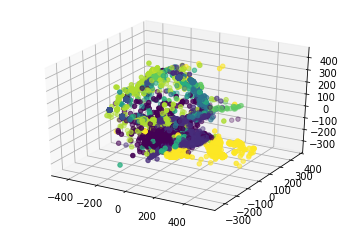

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
embedding = MDS(n_components=3)
X_train_transformed = embedding.fit_transform(X_train)
ax.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], X_train_transformed[:, 2], c=Y_train)